In [1]:
from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
%matplotlib inline

Please add SURFE to your environment variables to specify the location 
 of the SURFE binaries
Cannot import Surfe


In [36]:
#density='Sparse'
density='Full'

dips = pd.read_csv('../%s/Dips.csv'%density,delimiter=';')
#points_file_names = ['../Full/H1.csv','../BPoints.csv','../CPoints.csv','../DPoints.csv']
#section_file_names = ['../ASection.csv','../BSection.csv','../CSection.csv','../DSection.csv']

# import all of the csv into the same dataframe
dfs = []
for f in glob.glob('../%s/*H*'%density):
    #*f in points_file_names:
#     dfs.append(pd.read_csv(f,delimiter=';'))
    dfs.append(pd.read_csv(f,delimiter=';'))

points = pd.concat(dfs,axis=0,ignore_index=True)



In [37]:
dips['ny'] = 0
dips['feature_name']= 'strati'
dips.rename(columns={'OrientX':'nx','OrientZ':'nz'},inplace=True)
dips.loc[dips['nx']<-100,'nx'] = np.nan
dips.loc[dips['nz']<-100,'nz'] = np.nan

In [38]:
points.rename(columns={'0':'Z','Strati':'val'},inplace=True)
points['feature_name'] = 'strati'
vals = points['val'].unique()

In [39]:
data = pd.concat([points,dips])
data

,X,Y,Z,val,PART_ID,feature_name,nx,nz,ny
0,1.505406,0.295540,3.32516,0.0,1,strati,NaN,NaN,NaN
1,1.710851,0.284936,3.24865,0.0,1,strati,NaN,NaN,NaN
2,1.851495,-0.003390,3.19537,0.0,1,strati,NaN,NaN,NaN
3,2.240846,-0.237692,3.04396,0.0,1,strati,NaN,NaN,NaN
4,2.651827,-0.044266,2.90336,0.0,1,strati,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
55,4.831136,-0.031274,3.32890,NaN,28,strati,0.067834,0.997697,0.0
56,5.242005,0.113363,2.64891,NaN,29,strati,NaN,NaN,0.0
57,5.343713,0.129749,2.64929,NaN,29,strati,-0.003725,0.999993,0.0
58,5.563393,-0.035346,3.18587,NaN,30,strati,-0.999975,-0.007105,0.0


In [40]:
origin = (0, -1.5, 0,)
scale=7.
nsteps = np.array((321,51,91))
nsteps = nsteps / scale
nsteps = nsteps.astype(int)
# nsteps = np.array((19,28,15))

step_vector = np.array((0.05,0.05,0.05))
step_vector = step_vector*scale
maximum = origin+step_vector*nsteps

In [41]:
print(origin, maximum)

(0, -1.5, 0) [15.75  0.95  4.55]


## Using PLI with 1e5 elements

In [42]:
model = GeologicalModel(origin,maximum,rescale=False)
model.set_model_data(data)
strati = model.create_and_add_foliation('strati',nelements=1e5,interpolatortype='PLI',solver='pyamg')

Pyamg not installed using cg instead


D:\anaconda3\envs\gempy\lib\site-packages\LoopStructural\visualisation\model_visualisation.py:243: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  spacing=step_vector)



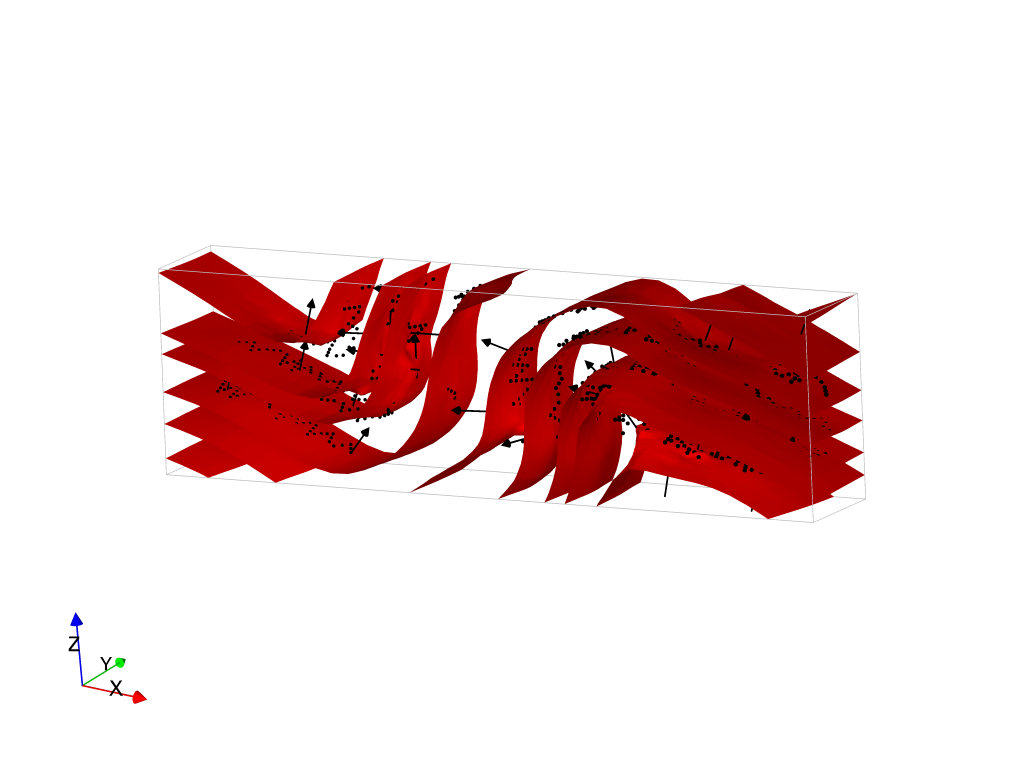

In [43]:
view = LavaVuModelViewer(model,)
view.add_data(model.features[0])
view.add_isosurface(model.features[0],slices=vals)
view.rotation = [-76.08123016357422, -27.247684478759766, -4.228135108947754]
view.display('hecho_PLI_1e5.png')


In [44]:
import re
def read_voxet(voxetname,propertyfile):
    """
    Read a gocad property file and the geometry information from the .vo file
    voxetname - is the path to the voxet file
    propertyfile is the path to the binary file
    Returns
    origin numpy array
    voxet_extent - is the length of each axis of the voxet
    N is the number of steps in the voxet
    array is the property values
    steps is the size of the step vector for the voxet 
    """
    array = np.fromfile(propertyfile,dtype='float32')
    array = array.astype('<f4') # little endian
    with open(voxetname,'r') as file:
        for l in file:
            if 'AXIS_O ' in l:
                origin = np.array(re.findall(r"[-+]?\d*\.?\d+|[-+]?\d+",l)).astype(float)
            if 'AXIS_U ' in l:
                U = float(re.findall(r'[\d\.\d]+',l)[0])
            if 'AXIS_V ' in l:
                V = float(re.findall(r'[\d\.\d]+',l)[1])
            if 'AXIS_W ' in l:
                W = float(re.findall(r'[\d\.\d]+',l)[2])
            if 'AXIS_N ' in l:
                N = np.array(re.findall(r'[\d\.\d]+',l)).astype(int)
    voxet_extent = np.array([U,V,W])
    N[N<=1] = 2 #Make sure that 2D Voxets are handled
    steps = (voxet_extent ) / (N-1)
    return origin, voxet_extent, N, array, steps

def write_property_to_gocad_voxet(propertyfilename, propertyvalues):
    """
    This function writes a numpy array into the right format for a gocad
    voxet property file. This assumes there is a property already added to the .vo file,
    and is just updating the file.
    propertyfile - string giving the path to the file to write
    propertyvalues - numpy array nz,ny,nx ordering and in float format
    """
    propertyvalues = propertyvalues.astype('>f4') #big endian
#     array = propertyvalues.newbyteorder()
    propertyvalues.tofile(propertyfilename)

view.rotation

[-76.08123779296875, -27.247682571411133, -4.2281341552734375]

In [45]:
#from LoopStructural.utils.utils import write_property_to_gocad_voxet, read_voxet
origin, voxet_extent, N, array, steps = read_voxet('ResultVoxet.vo','ResultVoxet_Strati@@')
x = np.linspace(origin[0],voxet_extent[0]+origin[0],N[0])
y = np.linspace(origin[1],voxet_extent[1]+origin[1],N[1])
z = np.linspace(origin[2],voxet_extent[2]+origin[2],N[2])

xx, yy, zz = np.meshgrid(x,y,z,indexing='ij')
eval_points = model.scale(np.array([xx.flatten(order='F'),yy.flatten(order='F'),zz.flatten(order='F')]).T)
vals = strati['feature'].evaluate_value(eval_points)
vals2 = vals.reshape((N[2],N[1],N[0]))
write_property_to_gocad_voxet('ResultsLoopStructural_%sresult_PLI_1e5@@'%density,vals2.flatten(order='C'))

## Using FDI with 2e4 elements

In [46]:
model = GeologicalModel(origin,maximum,rescale=False)
model.set_model_data(data)
model.create_and_add_foliation('strati',nelements=1e5/5,interpolatortype='FDI',solver='pyamg')

Pyamg not installed using cg instead


In [47]:
view = LavaVuModelViewer(model,)
view.add_data(model.features[0])
view.add_isosurface(model.features[0],slices=vals)
view.rotation = [-76.08123016357422, -27.247684478759766, -4.228135108947754]
view.display('hecho_FDI_2e4.png')

KeyboardInterrupt: 

In [48]:
#from LoopStructural.utils.utils import write_property_to_gocad_voxet, read_voxet
origin, voxet_extent, N, array, steps = read_voxet('ResultVoxet.vo','ResultVoxet_Strati@@')
x = np.linspace(origin[0],voxet_extent[0]+origin[0],N[0])
y = np.linspace(origin[1],voxet_extent[1]+origin[1],N[1])
z = np.linspace(origin[2],voxet_extent[2]+origin[2],N[2])

xx, yy, zz = np.meshgrid(x,y,z,indexing='ij')
eval_points = model.scale(np.array([xx.flatten(order='F'),yy.flatten(order='F'),zz.flatten(order='F')]).T)
vals = model.features[0].evaluate_value(eval_points)
vals2 = vals.reshape((N[2],N[1],N[0]))
write_property_to_gocad_voxet('ResultsLoopStructural_%sresult_FDI_2e4@@'%density,vals2.flatten(order='C'))